In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [14]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

# 1. Data

In [15]:
datas = pd.read_csv("datas/movielens_small/ratings.csv")

datas.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


# 2. Data Analysis

In [16]:
# 1. describe (통계 정보 1. value)
datas.describe()

,userId,movieId,rating,timestamp
count,100004.000000,100004.000000,100004.000000,1.000040e+05
mean,347.011310,12548.664363,3.543608,1.129639e+09
std,195.163838,26369.198969,1.058064,1.916858e+08
min,1.000000,1.000000,0.500000,7.896520e+08
25%,182.000000,1028.000000,3.000000,9.658478e+08
50%,367.000000,2406.500000,4.000000,1.110422e+09
75%,520.000000,5418.000000,4.000000,1.296192e+09
max,671.000000,163949.000000,5.000000,1.476641e+09


In [17]:
# 2. info (통계 정보 2. data structure)
datas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100004 entries, 0 to 100003
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100004 non-null  int64  
 1   movieId    100004 non-null  int64  
 2   rating     100004 non-null  float64
 3   timestamp  100004 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


In [18]:
# 3. 불필요한 칼럼 제거
datas.drop("timestamp", axis=1, inplace=True)
datas.head()

,userId,movieId,rating
0,1,31,2.5
1,1,1029,3.0
2,1,1061,3.0
3,1,1129,2.0
4,1,1172,4.0


In [32]:
# 4. unique data set check
print("사용자 수 : {} 명".format(datas['userId'].unique().size))
print("평가된 영화 수 : {} 개".format(datas['movieId'].unique().size))

사용자 수 : 671 명
평가된 영화 수 : 9066 개


# 2. Matrix Factorization

## 1. MF Model Process

In [33]:
# 1. split train and test
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(datas, test_size=0.2, random_state=42)
print("Train dataset shape : {}".format(train_df.shape))
print("Test dataset shape : {}".format(test_df.shape))

Train dataset shape : (80003, 3)
Test dataset shape : (20001, 3)


In [34]:
# 2. set pivot
pivot_df = train_df.pivot_table("rating", index="userId", columns="movieId")
pivot_df.fillna(0, inplace=True)
pivot_df.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,160656,160718,161084,161155,161594,161830,161918,161944,162542,163949
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [164]:
# 3. Setting Value
Interaction = pivot_df.to_numpy()

num_user, num_item = Interaction.shape
latent_factor = 20
learning_rate = 0.01
reg = 0.01

In [165]:
# 4. Setting Latent Factor Matrix p_u(사용자), q_i(아이템)
p_u = np.random.normal(size=(num_user, latent_factor))
q_i = np.random.normal(size=(num_item, latent_factor))

print("사용자 수 : {} 명, 사용자 잠재 변수 행렬 shape {}".format(num_user, p_u.shape))
print("영화 수 : {} 개, 영화 잠재 변수 행렬 shape {}".format(num_item, q_i.shape))

사용자 수 : 671 명, 사용자 잠재 변수 행렬 shape (671, 20)
영화 수 : 8399 개, 영화 잠재 변수 행렬 shape (8399, 20)


#### 사용자, 아이템 별로 랜덤한 잠재 변수 행렬이 각 각의 요소의 크기만큼, latent_factor 사이즈 만큼 만들어진 것을 알 수 있음

In [166]:
# 5. Confidence ref.Inputs with varying confidence levels
user_confidence = (pivot_df > 0).sum(axis=1)
item_confidence = (pivot_df > 0).sum(axis=0)

## 사용자의 평점 빈도 수(크기가 될 수 있음) 및 해당 사용자가 평가한 영화의 평점 발생 빈도 수(크기가 될 수 있음)을 더해
### 평가에 대한 신뢰도 부여
confidences = train_df.apply(lambda x: 
                   user_confidence.loc[x['userId']] + 
                   item_confidence.loc[x['movieId']], axis=1)
train_df['confidence'] = confidences
train_df.head()

,userId,movieId,rating,confidence
37865,273,5816,4.5,138
46342,339,2028,4.5,229
64614,461,3895,0.5,555
41974,300,3578,4.5,170
50236,369,292,3.0,139


In [167]:
# 6. Set confidence pivot
confidence_df = train_df.pivot_table(values="confidence", index="userId", columns="movieId")
confidence_df.fillna(1, inplace=True)

confidence_matrix = confidence_df.to_numpy()

confidence_df.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,160656,160718,161084,161155,161594,161830,161918,161944,162542,163949
userId,,,,,,,,,,,,,,,,,,,,,
1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,163.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
5,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [168]:
# 7. scaling confidence matrix
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled_confidence = scaler.fit_transform(confidence_matrix)
scaled_confidence += 0.0001
scaled_confidence

array([[1.00000000e-04, 1.00000000e-04, 1.00000000e-04, ...,
        1.00000000e-04, 1.00000000e-04, 1.00000000e-04],
       [1.00000000e-04, 1.00000000e-04, 1.00000000e-04, ...,
        1.00000000e-04, 1.00000000e-04, 1.00000000e-04],
       [1.00000000e-04, 1.00000000e-04, 1.00000000e-04, ...,
        1.00000000e-04, 1.00000000e-04, 1.00000000e-04],
       ...,
       [1.00000000e-04, 1.00000000e-04, 1.00000000e-04, ...,
        1.00000000e-04, 1.00000000e-04, 1.00000000e-04],
       [1.00000000e-04, 1.00000000e-04, 1.00000000e-04, ...,
        1.00000000e-04, 1.00000000e-04, 1.00000000e-04],
       [1.38975768e-01, 1.00000000e-04, 1.00000000e-04, ...,
        1.00000000e-04, 1.00000000e-04, 1.00000000e-04]])

In [169]:
# 8. bias setting
b_u = np.zeros(num_user)
b_i = np.zeros(num_item)
b = np.mean(Interaction[Interaction != 0])

In [181]:
# 9. test data setting
test_Interaction = test_df.pivot_table("rating", index="userId", columns="movieId")
test_Interaction.fillna(0, inplace=True)
test_Interaction = test_Interaction.to_numpy()

In [182]:
# 10. func get each prediction
def get_each_prediction(i_u, i_i):
    return b + b_u[i_u] + b_i[i_i] + np.dot(p_u[i_u, :], q_i[i_i, :].T)

In [184]:
# 11. func get whole prediction
def get_whole_prediction():
    return b + b_u[:, np.newaxis] + b_i[np.newaxis:,] + np.dot(p_u, q_i.T)

In [180]:
# 12. func gradient_descent
def gradient_descent(i_u, i_i, rating):
    prediction = get_each_prediction(i_u, i_i)
    
    dbu = -2 * scaled_confidence[i_u][i_i] * (rating - b_u[i_u] - b_i[i_i] - b - prediction) + 2 * reg * b_u[i_u]
    dbi = -2 * scaled_confidence[i_u][i_i] * (rating - b_u[i_u] - b_i[i_i] - b - prediction) + 2 * reg * b_i[i_i]
    
    b_u[i_u] -= learning_rate * dbu
    b_i[i_i] -= learning_rate * dbi
    
    dp = -2 * scaled_confidence[i_u][i_i] * \
             (rating - b_u[i_u] - b_i[i_i] - b - prediction) * q_i[i_i,:] + 2 * (reg * p_u[i_u, :])
    dq = -2 * scaled_confidence[i_u][i_i] * \
             (rating - b_u[i_u] - b_i[i_i] - b - prediction) * p_u[i_u,:] + 2 * (reg * q_i[i_i, :])
    
    p_u[i_u, :] -= learning_rate * dp
    q_i[i_i, :] -= learning_rate * dq

In [194]:
# 13. loss function
def test_loss():
    xi, yi = test_Interaction.nonzero()
    predicted = get_whole_prediction()
    test_loss = 0
    for x, y in zip(xi, yi):
        test_loss += np.power(test_Interaction[x, y] - predicted[x, y], 2)
    return np.sqrt(test_loss) / len(xi)

def loss():
    xi, yi = Interaction.nonzero()
    predicted = get_whole_prediction()
    test_loss = 0
    for x, y in zip(xi, yi):
        test_loss += np.power(Interaction[x, y] - predicted[x, y], 2)
    return np.sqrt(test_loss) / len(xi)

In [196]:
# 14. fitting
epoch = 30
for _epoch in range(epoch):
    for i_u in range(num_user):
        for i_i in range(num_item):
            if Interaction[i_u, i_i] > 0:
                gradient_descent(i_u, i_i, Interaction[i_u, i_i])
    _loss = loss()
    _test_loss = test_loss()
    
    print("Epoch: {} ; loss = {} ; test_loss = {}".format(_epoch + 1, _loss, _test_loss))

Epoch: 1 ; loss = 0.009842591996501383 ; test_loss = 0.02109827710064779
Epoch: 2 ; loss = 0.00892243924242637 ; test_loss = 0.019615114632379683
Epoch: 3 ; loss = 0.008460109921498154 ; test_loss = 0.018862783988576038
Epoch: 4 ; loss = 0.008174064544221432 ; test_loss = 0.018391934458413625
Epoch: 5 ; loss = 0.007977686627530652 ; test_loss = 0.018064221297647298
Epoch: 6 ; loss = 0.0078339100878419 ; test_loss = 0.017820494797446344
Epoch: 7 ; loss = 0.007723911702934595 ; test_loss = 0.017630783047522313
Epoch: 8 ; loss = 0.0076370000918445065 ; test_loss = 0.017478100511656998
Epoch: 9 ; loss = 0.00756660376182515 ; test_loss = 0.017352020995042686
Epoch: 10 ; loss = 0.007508440651348537 ; test_loss = 0.01724575193367208
Epoch: 11 ; loss = 0.00745959278367101 ; test_loss = 0.01715466029004969
Epoch: 12 ; loss = 0.007418000087698947 ; test_loss = 0.017075468976900137
Epoch: 13 ; loss = 0.00738216574465912 ; test_loss = 0.017005790512647993
Epoch: 14 ; loss = 0.007350975876028463 ; 

## 2. Use

In [202]:
# 1. model setting
from model import MatrixFactorization

train_df, test_df = train_test_split(datas, test_size=0.2, random_state=42)
model = MatrixFactorization(train_df, test_df)

In [204]:
# 2. Train
model.fit(20)

Epoch: 1 ; loss = 0.008745060881322191 ; test_loss = 0.019400867990155474
Epoch: 2 ; loss = 0.008350408080622214 ; test_loss = 0.018710434531649625
Epoch: 3 ; loss = 0.008097700282699105 ; test_loss = 0.01826324270561757
Epoch: 4 ; loss = 0.007920893357776803 ; test_loss = 0.017946254857037113
Epoch: 5 ; loss = 0.007789868125789141 ; test_loss = 0.01770813707142332
Epoch: 6 ; loss = 0.007688747142350441 ; test_loss = 0.017521745353344075
Epoch: 7 ; loss = 0.007608296768031102 ; test_loss = 0.01737126150195637
Epoch: 8 ; loss = 0.007542754148027116 ; test_loss = 0.017246783252550163
Epoch: 9 ; loss = 0.007488323890916858 ; test_loss = 0.017141771742767695
Epoch: 10 ; loss = 0.007442399282776297 ; test_loss = 0.0170517236980171
Epoch: 11 ; loss = 0.007403128701974775 ; test_loss = 0.016973431682254306
Epoch: 12 ; loss = 0.007369160101064049 ; test_loss = 0.016904547252892883
Epoch: 13 ; loss = 0.007339483164691938 ; test_loss = 0.016843310788045983
Epoch: 14 ; loss = 0.007313327943088504

    epoch  train_loss  test_loss
0       0    0.008745   0.019401
1       1    0.008350   0.018710
2       2    0.008098   0.018263
3       3    0.007921   0.017946
4       4    0.007790   0.017708
5       5    0.007689   0.017522
6       6    0.007608   0.017371
7       7    0.007543   0.017247
8       8    0.007488   0.017142
9       9    0.007442   0.017052
10     10    0.007403   0.016973
11     11    0.007369   0.016905
12     12    0.007339   0.016843
13     13    0.007313   0.016788
14     14    0.007290   0.016739
15     15    0.007269   0.016693
16     16    0.007251   0.016652
17     17    0.007234   0.016614
18     18    0.007218   0.016578
19     19    0.007204   0.016545


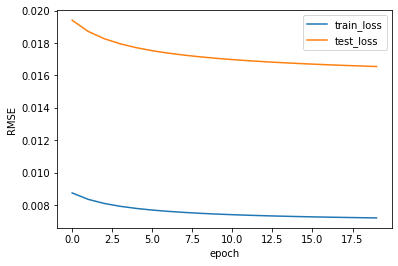

In [207]:
# #. Result
history = model.history

df = pd.DataFrame(history)
df.columns= ["epoch","train_loss","test_loss"]
print(df)
df.loc[:][["train_loss","test_loss"]].plot()
plt.xlabel("epoch")
plt.ylabel("RMSE")
plt.legend()
plt.show()